# 16장 Model Build from Scratch
- https://haystar.tistory.com/94

* "부록3 매트플롯립 입문"에서 한글 폰트를 올바르게 출력하기 위한 설치 방법을 설명했다. 설치 방법은 다음과 같다.

In [ ]:
!sudo apt-get install -y fonts-nanum* | tail -n 1
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 4.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 31 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such 

In [1]:
# 필요 라이브러리 설치

!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1
w = !apt install tree
print(w[-2])

'apt' is not recognized as an internal or external command,


* 모든 설치가 끝나면 한글 폰트를 바르게 출력하기 위해 **[런타임]** -> **[런타임 다시시작]**을 클릭한 다음, 아래 셀부터 코드를 실행해 주십시오.

In [2]:
# 라이브러리 임포트

# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# 폰트 관련 용도
import matplotlib.font_manager as fm

# Colab, Linux
# 나눔 고딕 폰트의 경로 명시
# path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
# font_name = fm.FontProperties(fname=path, size=10).get_name()

# Window 
font_name = "NanumBarunGothic"

# Mac
# font_name = "AppleGothic"

ModuleNotFoundError: No module named 'numpy'

In [1]:
# 파이토치 관련 라이브러리

import torch
from torch import nn, optim
from torchinfo import summary
from torchviz import make_dot
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader

In [3]:
# warning 표시 끄기
import warnings
warnings.simplefilter('ignore')

# 기본 폰트 설정
plt.rcParams['font.family'] = font_name

# 기본 폰트 사이즈 변경
plt.rcParams['font.size'] = 14

# 기본 그래프 사이즈 변경
plt.rcParams['figure.figsize'] = (6,6)

# 기본 그리드 표시
# 필요에 따라 설정할 때는, plt.grid()
plt.rcParams['axes.grid'] = True
plt.rcParams["grid.linestyle"] = ":"

# 마이너스 기호 정상 출력
plt.rcParams['axes.unicode_minus'] = False

# 넘파이 부동소수점 자릿수 표시
np.set_printoptions(suppress=True, precision=4)

In [4]:
# GPU 디바이스 할당

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### 공통 함수 불러오기

In [6]:
# 공통 함수 다운로드
!git clone https://github.com/wikibook/pythonlibs.git

# # 공통 함수 불러오기
from pythonlibs.torch_lib1 import *


# # 공통 함수 확인
print(README)

Common Library for PyTorch
Author: M. Akaishi


## 데이터 준비

In [5]:
# 분류 클래스명 정의

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 분류 클래스 수는 10
n_output = len(classes)

In [6]:
# Transforms 정의

# 학습 데이터용 : 정규화에 반전과 RandomErasing 추가
transform_train = transforms.Compose([
  transforms.Resize(112),
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.RandomRotation(20),
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5), 
])

# 검증 데이터용 : 정규화만 실시
transform = transforms.Compose([
  transforms.Resize(112),
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5)
])

In [7]:
# 데이터 취득용 함수 dataset
data_root = './data'

train_set = datasets.CIFAR10(
    root = data_root, 
    train = True,
    download = True, 
    transform = transform_train)

# 검증 데이터셋
test_set = datasets.CIFAR10(
    root = data_root, 
    train = False, 
    download = True, 
    transform = transform)

In [8]:
# 배치 사이즈 지정
batch_size = 50

# 데이터로더

# 훈련용 데이터로더
# 훈련용이므로 셔플을 True로 설정함
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

# 검증용 데이터로더
# 검증용은 셔플이 필요하지 않음
test_loader = DataLoader(test_set,  batch_size=batch_size, shuffle=False) 

## 모델 만들기

## BasicBlock

In [ ]:
import torch.nn as nn
from typing import Optional

class BasicBlock(nn.Module):
    expansion = 1  # Output channels are the same as input channels
    
    def __init__(self, inplanes: int, planes: int, stride: int = 1,
                 downsample: Optional[nn.Module] = None, groups: int = 1,
                 dilation: int = 1, norm_layer: Optional[nn.Module] = None):
        super().__init__()
        
        # Normalization layer (default to BatchNorm2d if not specified)
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        # First convolutional layer (3x3 conv, stride is applied)
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                               padding=dilation, groups=groups, bias=False, dilation=dilation)
        self.bn1 = norm_layer(planes)  # BatchNorm2d after the first convolution
        self.relu = nn.ReLU(inplace=True)  # ReLU activation function

        # Second convolutional layer (3x3 conv, no stride)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=dilation, groups=groups, bias=False, dilation=dilation)
        self.bn2 = norm_layer(planes)  # BatchNorm2d after the second convolution

        # Optional downsample layer (to adjust dimensions of input and output if necessary)
        self.downsample = downsample
        # self.downsample = nn.Sequential(
        # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, bias=False),
        # nn.BatchNorm2d(out_channels)

        self.stride = stride

    def forward(self, x):
        identity = x  # Store the input for the residual connection

        # Apply the first convolutional layer followed by BatchNorm and ReLU
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # Apply the second convolutional layer followed by BatchNorm
        out = self.conv2(out)
        out = self.bn2(out)

        # If downsampling is needed (i.e., the dimensions don't match), apply the downsample layer
        if self.downsample is not None:
            identity = self.downsample(x)

        # Add the residual (skip connection)
        out += identity
        out = self.relu(out)  # Apply ReLU activation after adding the residual

        return out


## Bottleneck

In [ ]:
import torch.nn as nn
from typing import Optional

class Bottleneck(nn.Module):
    expansion = 4  # Output channel expansion factor

    def __init__(self, inplanes: int, planes: int, stride: int = 1,
                 downsample: Optional[nn.Module] = None, groups: int = 1, 
                 base_width: int = 64, dilation: int = 1,
                 norm_layer: Optional[nn.Module] = None):
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        # Width for the 1x1 and 3x3 convolutions
        width = int(planes * (base_width / 64.)) * groups # channel

        # 1x1 Convolution (Reduce dimensions)
        self.conv1 = nn.Conv2d(inplanes, width, kernel_size=1, stride=1, bias=False)
        self.bn1 = norm_layer(width)

        # 3x3 Convolution (Main computation)
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride, padding=dilation,
                               groups=groups, dilation=dilation, bias=False)
        self.bn2 = norm_layer(width)

        # 1x1 Convolution (Expand dimensions)
        self.conv3 = nn.Conv2d(width, planes * self.expansion, kernel_size=1, stride=1, bias=False)
        self.bn3 = norm_layer(planes * self.expansion)

        # Downsample layer for residual connection
        self.downsample = downsample
        self.stride = stride
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x

        # First layer: 1x1 Convolution
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # Second layer: 3x3 Convolution
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        # Third layer: 1x1 Convolution
        out = self.conv3(out)
        out = self.bn3(out)

        # Residual connection
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


# ResNet18 from scratch

In [14]:
import torch
import torch.nn as nn
from typing import Type, List, Optional
# Type[nn.Module] =  BasicBlock (nn.Module을 상속한 클래스)
# Optional[nn.Module] = nn.Linear(...) 또는 None (nn.Module 인스턴스 또는 None)

# BasicBlock for ResNet18
class BasicBlock(nn.Module):
    expansion = 1  # Number of output channels will be same as input channels
    
    def __init__(self, inplanes: int, planes: int, stride: int = 1,
                 downsample: Optional[nn.Module] = None, groups: int = 1,
                 dilation: int = 1, norm_layer: Optional[nn.Module] = None):
        super().__init__()
        
        # Default normalization layer is BatchNorm2d
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        # First Convolution Layer
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                               padding=dilation, groups=groups, bias=False, dilation=dilation)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)

        # Second Convolution Layer
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=dilation, groups=groups, bias=False, dilation=dilation)
        self.bn2 = norm_layer(planes)

        # Downsample layer for matching dimensions
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x  # Store the input for the skip connection

        # Apply first convolution and batch normalization
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # Apply second convolution and batch normalization
        out = self.conv2(out)
        out = self.bn2(out)

        # If downsampling is required, apply it to the identity
        if self.downsample is not None:
            identity = self.downsample(x)

        # Add the residual (skip connection)
        out += identity
        out = self.relu(out)  # Final ReLU activation

        return out

# ResNet18 Model
class ResNet18(nn.Module):
    def __init__(self, block: Type[nn.Module], layers: List[int], num_classes: int = 1000,
                 groups: int = 1, width_per_group: int = 64, 
                 norm_layer: Optional[nn.Module] = None):
        super().__init__()

        # Default normalization layer is BatchNorm2d
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        # Initialize parameters
        self.inplanes = 64
        self.dilation = 1
        self.groups = groups
        self.base_width = width_per_group

        # Initial Convolution Layer (7x7 Conv)
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet layers (consists of blocks of BasicBlock)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # Fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # Initialize parameters
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block: Type[nn.Module], planes: int, blocks: int, stride: int = 1) -> nn.Sequential:
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                self._norm_layer(planes * block.expansion),
            )

        layers = [block(self.inplanes, planes, stride, downsample, groups=self.groups, 
                        dilation=self.dilation, norm_layer=self._norm_layer)]
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, stride=1, downsample=None, groups=self.groups, 
                                dilation=self.dilation, norm_layer=self._norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Initial layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Apply ResNet layers (BasicBlock residual layers)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Pooling and fully connected layer
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

# Function to instantiate the ResNet18 model
def resnet18(num_classes: int = 1000, norm_layer: Optional[nn.Module] = None) -> ResNet18:
    """Constructs a ResNet-18 model."""
    return ResNet18(
        block=BasicBlock,  # Use the BasicBlock for ResNet-18
        layers=[2, 2, 2, 2],  # ResNet-18 has 2 blocks per stage
        num_classes=num_classes,
        norm_layer=norm_layer
    )

# Example usage
net = resnet18(num_classes=10)  # Example for 10 classes (e.g., CIFAR-10)


In [15]:
print(net)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)


In [36]:
net = net.to(device)
summary(net,(100, 3, 112, 112))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet18                                 [100, 10]                 --
├─Conv2d: 1-1                            [100, 64, 56, 56]         9,408
├─BatchNorm2d: 1-2                       [100, 64, 56, 56]         128
├─ReLU: 1-3                              [100, 64, 56, 56]         --
├─MaxPool2d: 1-4                         [100, 64, 28, 28]         --
├─Sequential: 1-5                        [100, 64, 28, 28]         --
│    └─BasicBlock: 2-1                   [100, 64, 28, 28]         --
│    │    └─Conv2d: 3-1                  [100, 64, 28, 28]         36,864
│    │    └─BatchNorm2d: 3-2             [100, 64, 28, 28]         128
│    │    └─ReLU: 3-3                    [100, 64, 28, 28]         --
│    │    └─Conv2d: 3-4                  [100, 64, 28, 28]         36,864
│    │    └─BatchNorm2d: 3-5             [100, 64, 28, 28]         128
│    │    └─ReLU: 3-6                    [100, 64, 28, 28]         --
│

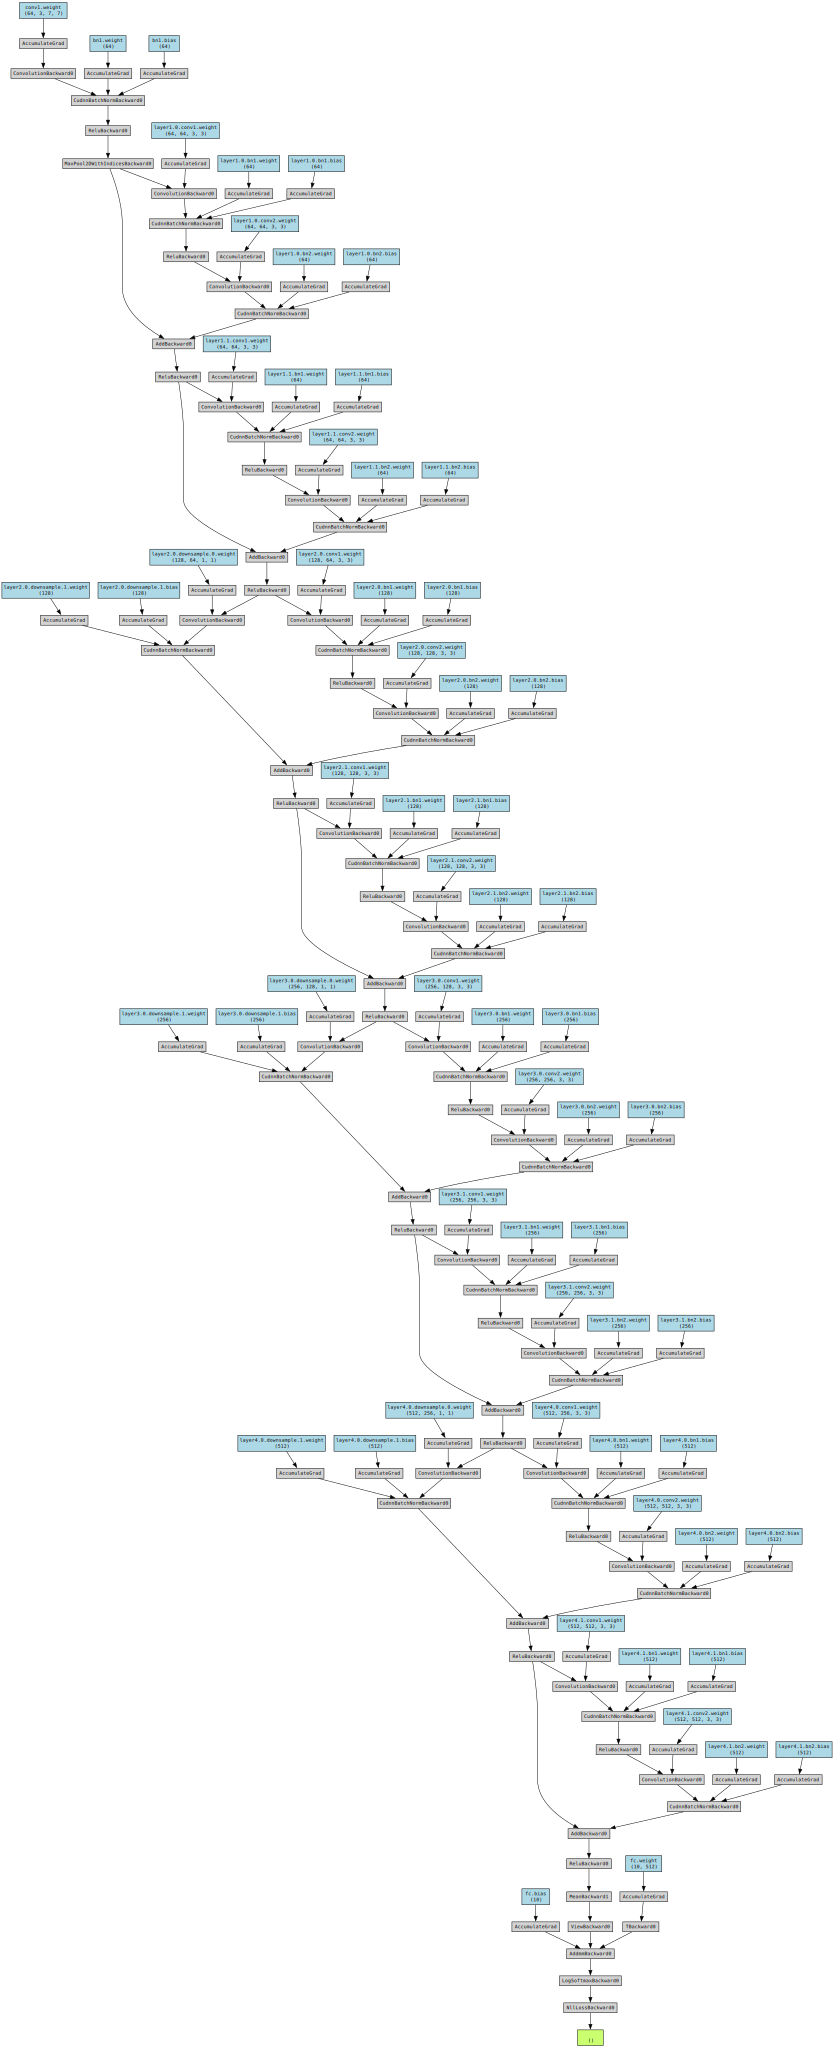

In [37]:
# 손실 계산 그래프 시각화

criterion = nn.CrossEntropyLoss()
loss = eval_loss(test_loader, device, net, criterion)
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

In [38]:
# 학습률
lr = 0.001

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()

# 최적화 함수 정의
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# history 파일 초기화
history = np.zeros((0, 5))

In [39]:
# 학습
num_epochs = 5
history = fit(net, optimizer, criterion, num_epochs, 
        train_loader, test_loader, device, history)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/5], loss: 1.67881 acc: 0.37534 val_loss: 1.40021, val_acc: 0.48730


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [2/5], loss: 1.30478 acc: 0.52360 val_loss: 1.18151, val_acc: 0.57310


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [3/5], loss: 1.13530 acc: 0.59180 val_loss: 1.03601, val_acc: 0.63070


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [4/5], loss: 1.00664 acc: 0.64066 val_loss: 1.04888, val_acc: 0.63230


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [5/5], loss: 0.91432 acc: 0.67626 val_loss: 0.89390, val_acc: 0.68010


초기상태 : 손실 : 1.40021  정확도 : 0.48730
최종상태 : 손실 : 0.89390 정확도 : 0.68010


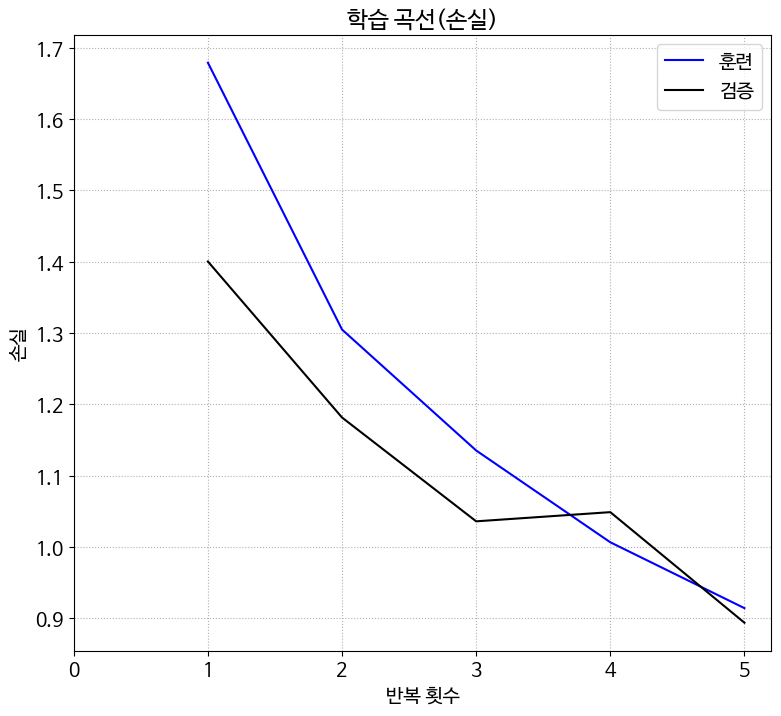

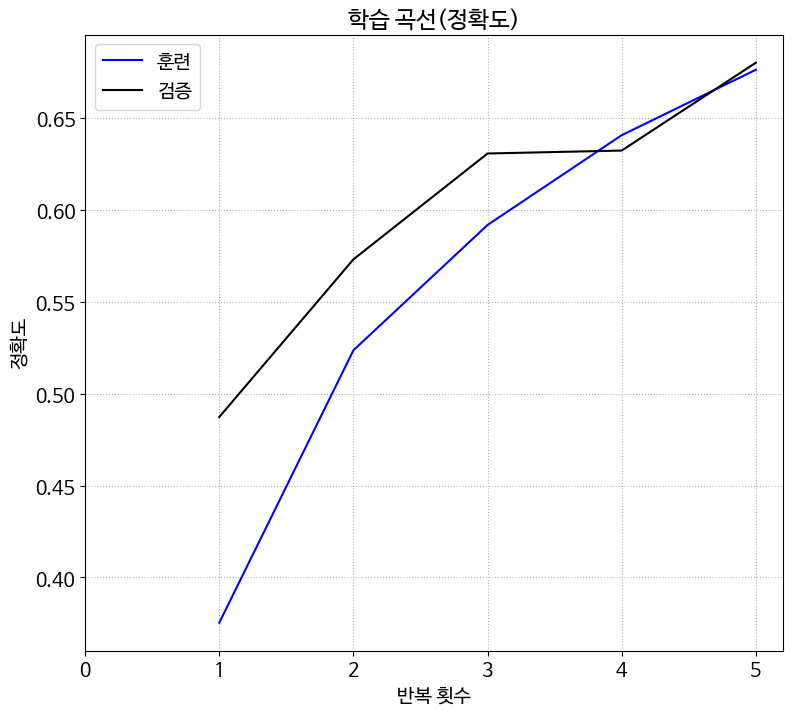

In [40]:
# 결과 요약
evaluate_history(history)

len(images) =  50


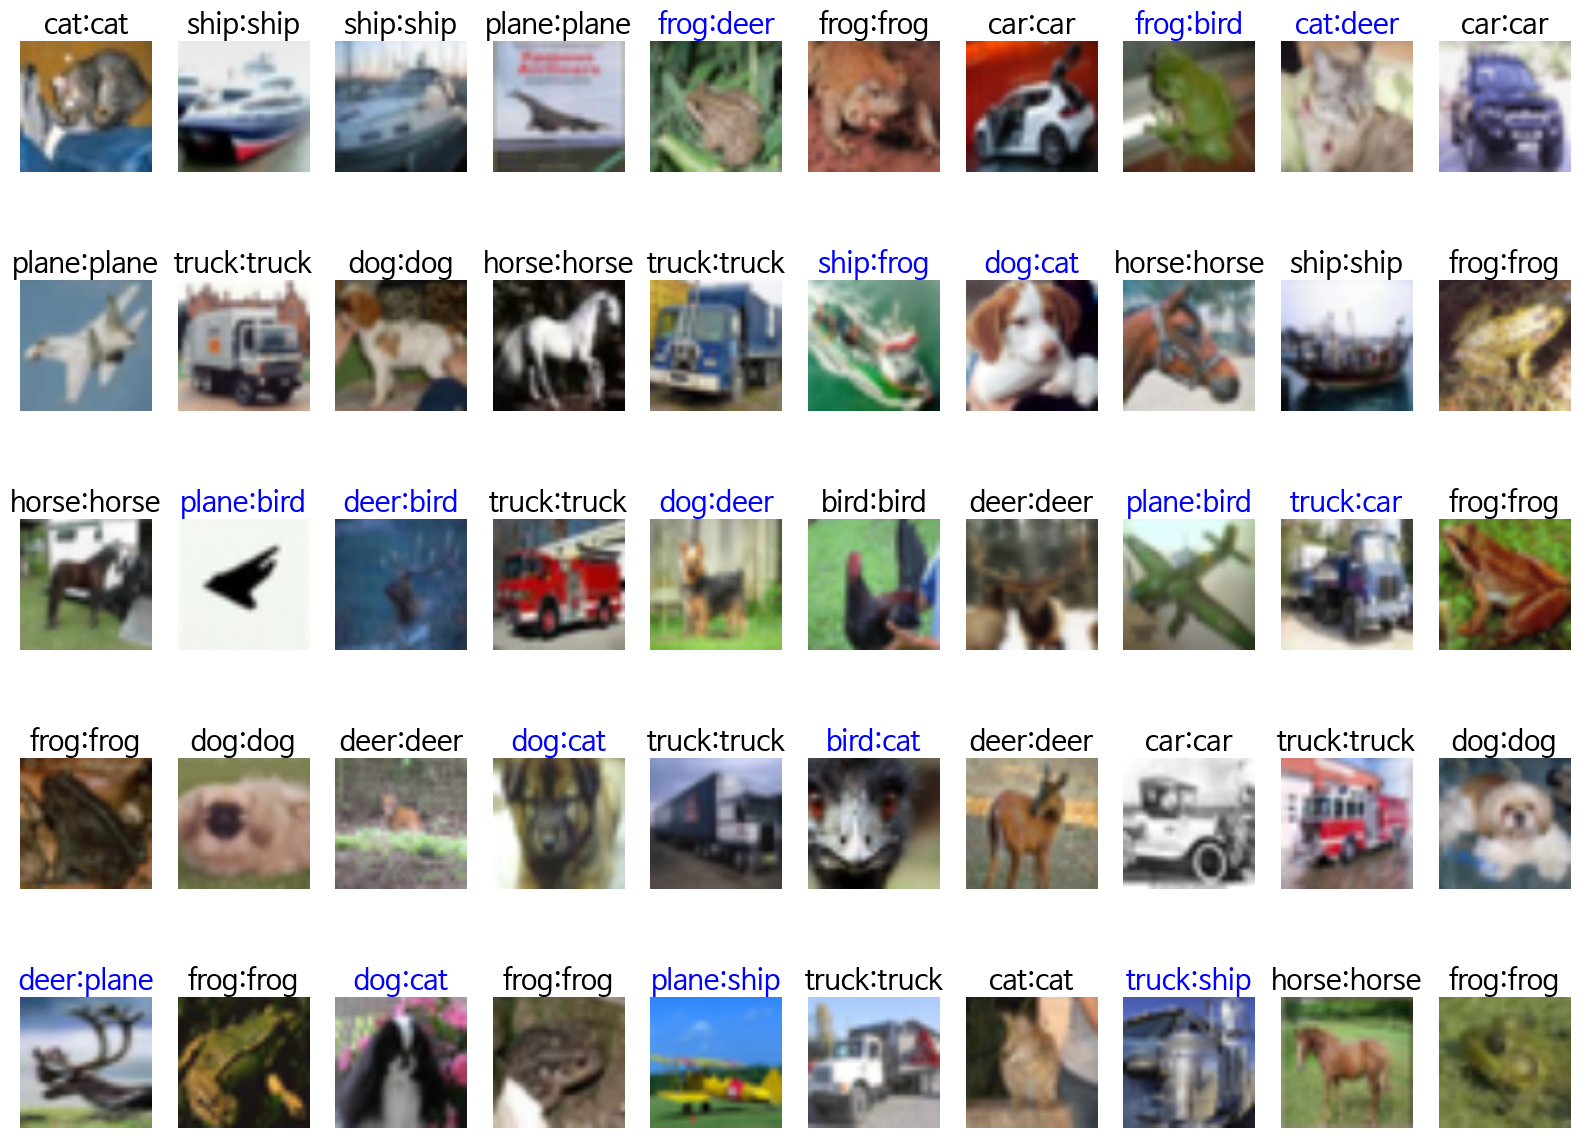

In [41]:
# 이미지와 정답, 예측 결과를 함께 표시
show_images_labels(test_loader, classes, net, device)